In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import networkx as nx
from rdkit import Chem
from rdkit.Chem import RDKFingerprint
from node2vec import Node2Vec
import pandas as pd
from tqdm.notebook import tqdm
import seaborn as sns
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.linear_model import LinearRegression, HuberRegressor, Ridge, TweedieRegressor, GammaRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error as mse, mean_absolute_error as mae
from sklearn.feature_selection import SelectKBest, f_regression
from catboost import CatBoostRegressor, CatBoostClassifier
from lazypredict.Supervised import LazyRegressor   

import shap
shap.initjs()

from utils.threading import ThreadWithReturnValue

In [4]:
def get_graph_vector(graph: nx.Graph) -> np.ndarray:
    node2vec = Node2Vec(graph, dimensions=16, walk_length=15, num_walks=50, workers=6)
    model = node2vec.fit(window=10, min_count=1)

    node_embeddings = {str(node): model.wv[str(node)] for node in graph.nodes()}
    node_embeddings = np.array(list(node_embeddings.values()))

    graph_embedding = np.mean(node_embeddings, axis=0)

    return graph_embedding

def smiles_to_graph(smiles: str) -> nx.Graph:
    mol = Chem.MolFromSmiles(smiles)

    print('Reading smile: %s' % smiles)

    graph = nx.Graph()

    for atom in mol.GetAtoms():
        graph.add_node(atom.GetIdx(),
                       atomic_num=atom.GetAtomicNum(),
                       is_aromatic=atom.GetIsAromatic(),
                       atom_symbol=atom.GetSymbol())

    for bond in mol.GetBonds():
        graph.add_edge(bond.GetBeginAtomIdx(),
                       bond.GetEndAtomIdx(),
                       bond_type=bond.GetBondType())

    return graph

In [9]:
data = pd.read_csv('datasets/Acute Toxicity_mouse_intraperitoneal_LD50.csv')
data

,TAID,Pubchem CID,IUPAC Name,SMILES,Canonical SMILES,InChIKey,mouse_intraperitoneal_LD50
0,TOX-145,785,"benzene-1,4-diol",Oc1ccc(O)cc1,Oc1ccc(O)cc1,QIGBRXMKCJKVMJ-UHFFFAOYSA-N,3.04
1,TOX-245,5453,tris(aziridin-1-yl)-sulfanylidene-lambda5-phos...,S=P(N1CC1)(N1CC1)N1CC1,S=P(N1CC1)(N1CC1)N1CC1,FOCVUCIESVLUNU-UHFFFAOYSA-N,4.24
2,TOX-1273,727,"1,2,3,4,5,6-hexachlorocyclohexane",ClC1C(Cl)C(Cl)C(Cl)C(Cl)C1Cl,ClC1C(Cl)C(Cl)C(Cl)C(Cl)C1Cl,JLYXXMFPNIAWKQ-UHFFFAOYSA-N,3.37
3,TOX-1279,4091,"3-(diaminomethylidene)-1,1-dimethylguanidine",CN(C)C(=N)N=C(N)N,CN(C)C(=N)N=C(N)N,XZWYZXLIPXDOLR-UHFFFAOYSA-N,2.64
4,TOX-1282,10364,2-methyl-5-propan-2-ylphenol,Cc1ccc(C(C)C)cc1O,Cc1ccc(C(C)C)cc1O,RECUKUPTGUEGMW-UHFFFAOYSA-N,3.31
...,...,...,...,...,...,...,...
35294,TOX-109816,14164316,[3-acetyloxy-2-(cyclohexylcarbamoylamino)-6-[[...,CC(=O)OC1C(NC(=O)NC2CCCCC2)OC(OC2C(OC3CCC4(C)C...,CC(=O)OC1C(NC(=O)NC2CCCCC2)OC(OC2C(OC3CCC4(C)C...,PTTQJFKYIWSJCJ-UHFFFAOYSA-N,3.47
35295,TOX-109817,216337,"7-[3-[cyclohexyl(methyl)amino]propyl]-1,3-dime...",CN(CCCn1cnc2c1c(=O)n(C)c(=O)n2C)C1CCCCC1,CN(CCCn1cnc2c1c(=O)n(C)c(=O)n2C)C1CCCCC1,YSSDOJFBBPZKBV-UHFFFAOYSA-N,3.45
35296,TOX-113361,3518,2-[2-(azocan-1-yl)ethyl]guanidine,N=C(N)NCCN1CCCCCCC1,N=C(N)NCCN1CCCCCCC1,ACGDKVXYNVEAGU-UHFFFAOYSA-N,3.17
35297,TOX-113362,5342,"4-[2-(benzenesulfinyl)ethyl]-1,2-diphenylpyraz...",O=C1C(CCS(=O)c2ccccc2)C(=O)N(c2ccccc2)N1c1ccccc1,O=C1C(CCS(=O)c2ccccc2)C(=O)N(c2ccccc2)N1c1ccccc1,MBGGBVCUIVRRBF-UHFFFAOYSA-N,3.61


In [10]:
data = data[['Canonical SMILES', 'mouse_intraperitoneal_LD50']].dropna()

In [14]:
data.rename(columns = {'mouse_intraperitoneal_LD50':'Toxicity Value'}, inplace = True)

In [15]:
data_sample = data.sample(8000)
mol_graphs = data_sample['Canonical SMILES'].apply(smiles_to_graph).values

Reading smile: C1CCN(CCC23CC4CC(CC(C4)C2)C3)CC1
Reading smile: CC1=NNC(N)=NN=C1
Reading smile: COc1ccc(C(=O)N2CCOCC2)cc1OC
Reading smile: Cc1ccc(C(=O)C(C)N2CCCCC2)c(C)c1
Reading smile: CCCNCCn1cnc2c1c(=O)n(C)c(=O)n2C
Reading smile: C=C(C)C(=O)N[N+](C)(C)CC(O)CCCCCCCCCC
Reading smile: Cc1cc(C(=O)NNCCO)no1
Reading smile: O=C(CCN1CCN(CCO)CC1)N(c1ccccc1)c1ccccc1
Reading smile: Cn1c(N)c(C(=O)NNc2ccccc2)sc1=S
Reading smile: COc1cc(C=NNC(=O)COc2ccc(C=C3C(=O)NN=C3C)cc2)ccc1O
Reading smile: COc1ccccc1C=C1NC(=S)N(c2ccccc2Cl)C1=O
Reading smile: COc1ccc2c(c1)N(C(=O)N(CCO)CCO)c1ccccc1S2
Reading smile: Cc1cc(Cl)ccc1Cn1nc(C(=O)O)c2ccccc21
Reading smile: CN(C)CCCN1c2ccccc2C2C(c3ccc(Cl)cc3)=NN(c3ccccc3)C2c2ccccc21
Reading smile: CC(C)(N)CN
Reading smile: CCN(CC)CCN(C(C)=O)c1ccsc1[N+](=O)[O-]
Reading smile: CCC(=O)C1C2CNCC1CN(CC=Cc1ccccc1)C2
Reading smile: C[N+](C)(CC(=O)c1ccc(Br)cc1)CC(O)COCc1ccco1
Reading smile: CCCCCCc1cc2c(cc1O)OC(C)(C)C1=C2CCCC1
Reading smile: NC(=O)C1=Cc2cc(Cl)cc(Cl)c2OC1
Reading 

In [ ]:
def get_graphs_embeddings(graphs):
    graph_embeddings = []
    
    for graph in tqdm(graphs):
        embedding = get_graph_vector(graph)
        graph_embeddings.append(embedding)
        
    return graph_embeddings

In [ ]:
thread_list, graph_embeddings = [], []
NUM_THREADS = 40

for batch in np.array_split(mol_graphs, NUM_THREADS):
    thread = ThreadWithReturnValue(target=get_graphs_embeddings, args=(batch,))
    thread_list.append(thread)
    thread.start()
    
for thread in thread_list:
    graph_embeddings.extend(thread.join())

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/18 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/28 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/25 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/22 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/13 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/34 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/31 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/18 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/23 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/14 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/18 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/27 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/19 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/21 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/28 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/9 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/31 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/15 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/24 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/18 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/21 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/22 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/21 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/19 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/17 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/25 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/25 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/22 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/9 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/22 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/21 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/18 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/18 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/23 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/15 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/23 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/7 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/17 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/19 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/14 [00:00<?, ?it/s]

Generating walks (CPU: 4):   0%|          | 0/8 [00:00<?, ?it/s]

Generating walks (CPU: 6): 100%|██████████| 8/8 [00:00<00:00, 2259.25it/s]

Generating walks (CPU: 4): 100%|██████████| 8/8 [00:00<00:00, 1736.05it/s]

Generating walks (CPU: 3):   0%|          | 0/8 [00:00<?, ?it/s]

Generating walks (CPU: 6): 100%|██████████| 8/8 [00:00<00:00, 7805.17it/s]

Generating walks (CPU: 3):   0%|          | 0/8 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/17 [00:00<?, ?it/s]

Generating walks (CPU: 3):   0%|          | 0/8 [00:00<?, ?it/s]

Generating walks (CPU: 2): 100%|██████████| 9/9 [00:00<00:00, 2499.42it/s]

Generating walks (CPU: 1): 100%|██████████| 9/9 [00:00<00:00, 2681.02it/s]

Computing transition probabilities:   0%|          | 0/28 [00:00<?, ?it/s]


Generating walks (CPU: 4):   0%|          | 0/8 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/9 [00:00<?, ?it/s]


Generating walks (CPU: 5): 100%|██████████| 8/8 [00:00<00:00, 3275.84it/s]

Computing transition probabilities:   0%|          | 0/28 [00:00<?, ?it/s]


Generating walks (CPU: 4):   0%|          | 0/8 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/9 [00:00<?, ?it/s]

Generating walks (CPU: 2):   0%|          | 0/9 [00:00<?, ?it/s]

Generating walks (CPU: 6): 100%|██████████| 8/8 [00:00<00:00, 6278.90it/s]

Computing transition probabilities:   0%|          | 0/22 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/20 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/27 [00:00<?, ?it/s]


Generating walks (CPU: 2):   0%|          | 0/9 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/30 [00:00<?, ?it/s]


Generating walks (CPU: 3): 100%|██████████| 8/8 [00:00<00:00, 1824.40it/s]

Computing transition probabilities:   0%|          | 0/18 [00:00<?, ?it/s]

Generating walks (CPU: 6): 100%|██████████| 8/8 [00:00<00:00, 3037.15it/s]

Computing transition probabilities:   0%|          | 0/20 [00:00<?, ?it/s]


Generating walks (CPU: 1): 100%|██████████| 9/9 [00:00<00:00, 2736.21it/s]

Computing transition probabilities:   0%|          | 0/24 [00:00<?, ?it/s]


Generating walks (CPU: 2): 100%|██████████| 9/9 [00:00<00:00, 2132.09it/s]


Computing transition probabilities:   0%|          | 0/12 [00:00<?, ?it/s]

Generating walks (CPU: 6): 100%|██████████| 8/8 [00:00<00:00, 4613.56it/s]

Computing transition probabilities:   0%|          | 0/23 [00:00<?, ?it/s]


Generating walks (CPU: 5):   0%|          | 0/8 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/30 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/23 [00:00<?, ?it/s]

Generating walks (CPU: 6): 100%|██████████| 8/8 [00:00<00:00, 2200.29it/s]

Computing transition probabilities:   0%|          | 0/14 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/22 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/21 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/26 [00:00<?, ?it/s]


Generating walks (CPU: 3): 100%|██████████| 8/8 [00:00<00:00, 1841.63it/s]

Generating walks (CPU: 4):   0%|          | 0/8 [00:00<?, ?it/s]04.50it/s]

Computing transition probabilities:   0%|          | 0/18 [00:00<?, ?it/s]


Generating walks (CPU: 5): 100%|██████████| 8/8 [00:00<00:00, 3923.12it/s]

Generating walks (CPU: 1): 100%|██████████| 9/9 [00:00<00:00, 2809.94it/s]

Computing transition probabilities:   0%|          | 0/16 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/21 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/20 [00:00<?, ?it/s]


Generating walks (CPU: 2): 100%|██████████| 9/9 [00:00<00:00, 3442.03it/s]

Computing transition probabilities:   0%|          | 0/14 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/16 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/21 [00:00<?, ?it/s]


Generating walks (CPU: 5): 100%|██████████| 8/8 [00:00<00:00, 3508.78it/s]

Computing transition probabilities:   0%|          | 0/29 [00:00<?, ?it/s]


Generating walks (CPU: 1): 100%|██████████| 9/9 [00:00<00:00, 3192.55it/s]


Computing transition probabilities:   0%|          | 0/31 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/21 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/23 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/22 [00:00<?, ?it/s]

Generating walks (CPU: 5): 100%|██████████| 8/8 [00:00<00:00, 3499.26it/s]

Computing transition probabilities:   0%|          | 0/15 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/13 [00:00<?, ?it/s]


Generating walks (CPU: 3): 100%|██████████| 8/8 [00:00<00:00, 2685.43it/s]

Computing transition probabilities:   0%|          | 0/23 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/12 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/20 [00:00<?, ?it/s]


Generating walks (CPU: 5): 100%|██████████| 8/8 [00:00<00:00, 2644.79it/s]

Computing transition probabilities:   0%|          | 0/31 [00:00<?, ?it/s]


Generating walks (CPU: 3): 100%|██████████| 8/8 [00:00<00:00, 1712.40it/s]

Computing transition probabilities:   0%|          | 0/11 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/18 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/14 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/17 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/11 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/28 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/19 [00:00<?, ?it/s]


Generating walks (CPU: 2): 100%|██████████| 9/9 [00:00<00:00, 3306.36it/s]

Generating walks (CPU: 6): 100%|██████████| 8/8 [00:00<00:00, 2013.59it/s]

Computing transition probabilities:   0%|          | 0/8 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/35 [00:00<?, ?it/s]


Generating walks (CPU: 2):   0%|          | 0/9 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/25 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/18 [00:00<?, ?it/s]

Generating walks (CPU: 5):   0%|          | 0/8 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/9 [00:00<?, ?it/s]

Generating walks (CPU: 3): 100%|██████████| 8/8 [00:00<00:00, 3177.20it/s]

Generating walks (CPU: 6): 100%|██████████| 8/8 [00:00<00:00, 6078.70it/s]

Computing transition probabilities:   0%|          | 0/23 [00:00<?, ?it/s]


Generating walks (CPU: 2):   0%|          | 0/9 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/30 [00:00<?, ?it/s]

Generating walks (CPU: 6):   0%|          | 0/8 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/27 [00:00<?, ?it/s]

Generating walks (CPU: 6): 100%|██████████| 8/8 [00:00<00:00, 1971.47it/s]

Computing transition probabilities:   0%|          | 0/23 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/26 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/14 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/14 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/10 [00:00<?, ?it/s]


Generating walks (CPU: 6):   0%|          | 0/8 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/57 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/12 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/22 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/31 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/20 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/22 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/20 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/22 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/23 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/22 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/25 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/18 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/26 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/23 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/21 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/14 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/12 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/28 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/13 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/19 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/23 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/14 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/18 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/18 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/17 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/17 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/28 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/15 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/14 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/32 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/17 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/26 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/21 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/40 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/31 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/16 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/22 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/8 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/15 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/26 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/12 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/21 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/12 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/14 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/23 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/30 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/41 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/31 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/16 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/17 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/20 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/19 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/25 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/25 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/15 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/38 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/19 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/22 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/10 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/23 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/24 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/15 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/17 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/24 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/7 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/22 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/25 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/31 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/18 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/32 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/24 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/10 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/11 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/23 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/18 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/22 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/14 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/21 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/7 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/22 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/27 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/23 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/12 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/16 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/24 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/22 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/22 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/17 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/20 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/19 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/8 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/12 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/19 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/21 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/8 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/25 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/32 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/23 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/22 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/25 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/19 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/14 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/18 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/21 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/18 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/32 [00:00<?, ?it/s]

In [ ]:
df = pd.DataFrame(columns=['f%s' % i for i in range(16)])

for embedding in graph_embeddings:
    row = {f"f%s" % i: embedding[i] for i in range(len(embedding))}
    df = df.append(row, ignore_index=True)

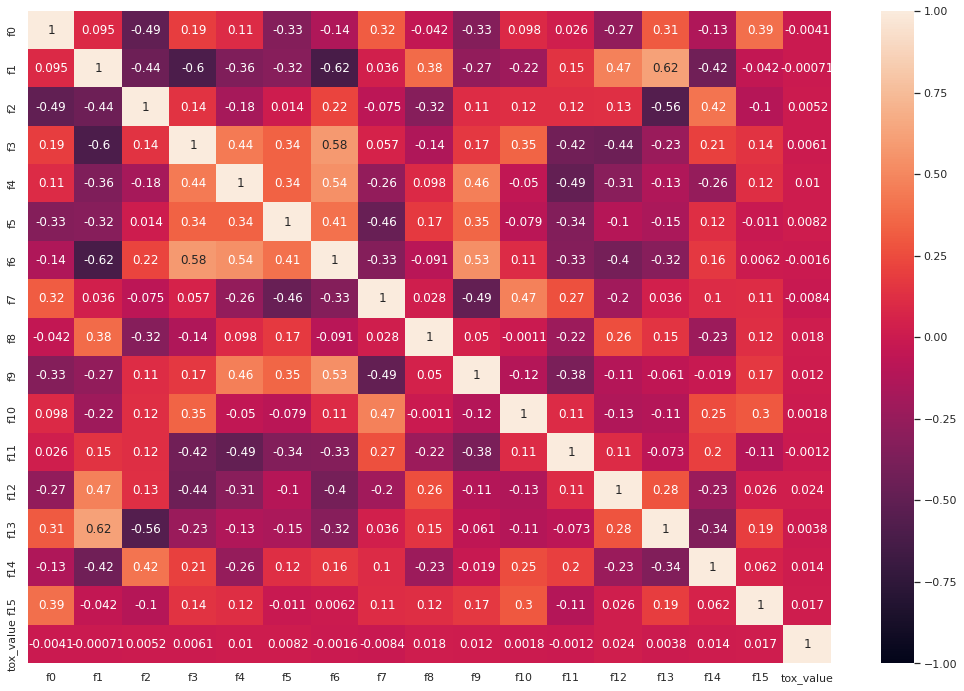

In [276]:
sns.set(rc={'figure.figsize':(18,12)})
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1);

In [140]:
df['tox_value'] = np.log(data['Toxicity Value'])

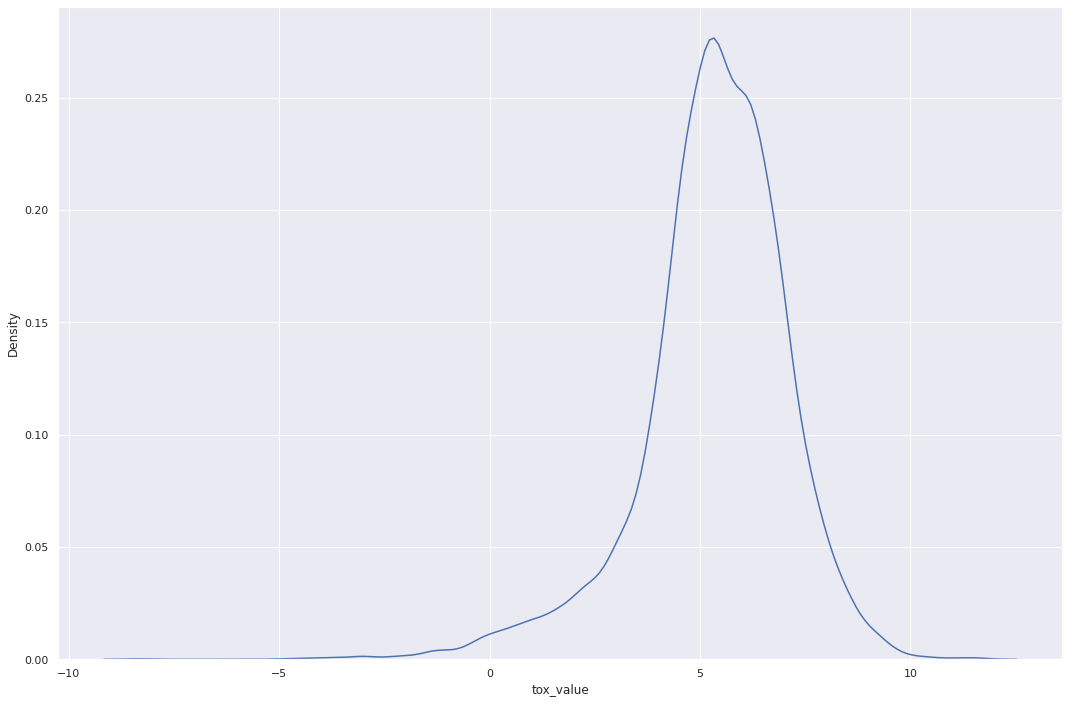

In [149]:
sns.kdeplot(df.tox_value);

In [83]:
df.to_csv("data/graph_embeddings.csv", index=False)

In [321]:
df = df.sample(frac=1)

df_class = df.dropna().tox_value.apply(lambda x: int((x > df['tox_value'].quantile(0.05)) & 
                                            (x < df['tox_value'].quantile(0.95))))

df_cut = df[(df['tox_value'] > df['tox_value'].quantile(0.05)) & (df['tox_value'] < df['tox_value'].quantile(0.95))]
X, y = df_cut.dropna().drop(columns=["tox_value"]).values, df_cut.dropna().tox_value.values

In [266]:
df

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,tox_value
5482,-0.422671,0.375715,0.127481,0.209588,-0.010822,0.158922,0.811402,-0.092726,0.339171,0.049956,0.129265,-0.020682,0.319143,-0.010013,-0.566191,-0.242554,6.907755
529,-0.226346,-0.021538,0.016183,0.454853,0.485689,0.358981,1.115127,-0.361354,0.127138,0.307638,0.010755,-0.126241,0.374759,0.037750,-0.633659,0.168807,5.857682
3920,0.128771,0.146965,-0.193990,0.406617,-0.005656,0.164371,0.772224,0.151877,-0.003171,-0.394951,0.132307,0.138865,-0.067107,-0.048592,-0.561127,-0.064986,5.010568
3546,-0.034200,0.305073,-0.003911,0.410074,-0.242805,0.071769,0.762758,0.079388,0.189495,-0.320677,0.204750,0.418926,0.026590,-0.028829,-0.479283,-0.175316,5.010615
5384,-0.228600,0.346740,-0.024474,0.219954,-0.025085,0.170520,0.881271,-0.151925,0.321776,-0.022448,0.039754,0.117206,0.436923,0.200572,-0.606160,-0.166390,3.688911
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5157,-0.119759,0.130273,-0.004885,0.688594,0.206309,0.318014,1.234522,-0.239105,0.231639,0.186200,0.129278,-0.301601,0.106314,0.041300,-0.540653,-0.114987,6.907510
616,-0.241296,-0.290891,-0.028123,0.753922,0.156081,0.477455,1.189014,-0.229924,0.199270,0.160618,0.247313,-0.147933,0.204702,-0.041328,-0.506083,-0.060054,0.039157
3666,-0.082790,0.219746,0.027284,0.476902,0.155928,0.115409,1.212365,-0.172948,0.138814,-0.118071,-0.017360,0.004406,0.193490,0.145784,-0.746877,-0.288597,6.109254
5890,-0.331895,0.320456,0.117599,0.279601,0.161596,0.176253,0.761550,-0.257998,0.257129,0.213013,-0.171925,-0.153917,0.576383,0.222949,-0.622353,-0.220525,6.699448


In [268]:
df_class.value_counts()

1    7103
0     790
Name: tox_value, dtype: int64

In [258]:
compound_classifier = CatBoostClassifier()

In [269]:
compound_classifier.fit(X, df_class, silent=True)

In [319]:
X = SelectKBest(f_regression, k=5).fit_transform(X, y)

In [320]:
folds = KFold(n_splits=7)

model = GammaRegressor()

for i, (train_index, test_index) in enumerate(folds.split(X, y)):
    model.fit(X[train_index], y[train_index])
    
    preds = model.predict(X[test_index])
    print(mae(preds, y[test_index]))
    print('------------')
    print(mae(np.exp(preds), np.exp(y[test_index])))
    print('------------')
    #print(r2_score(preds, y[test_index]))
    #print('-----')

1.0111641940392204
------------
340.26524933304427
------------
0.9894301524575361
------------
307.16489401078746
------------
0.9683667779375549
------------
319.2921820709479
------------
0.9894910564655491
------------
334.61387901702676
------------
0.9818174112442437
------------
305.1348535612551
------------
0.9691599676257178
------------
298.48025912978665
------------
0.997009701547147
------------
297.68090535117545
------------


In [314]:
cross_val_score(model, X, y, cv=5).mean()

-0.001496140830475845

In [295]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size=0.3,
                                                   random_state=42,
                                                   shuffle=True)

In [297]:
regressors = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = regressors.fit(X_train, X_test, y_train, y_test)

100%|██████████| 41/41 [00:32<00:00,  1.25it/s]


In [299]:
models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
LassoLarsCV,-0.01,-0.00,1.21,0.04
TweedieRegressor,-0.01,-0.00,1.21,0.02
GammaRegressor,-0.01,-0.00,1.21,0.02
LassoCV,-0.01,-0.00,1.21,0.10
ElasticNetCV,-0.01,-0.00,1.21,0.11
LarsCV,-0.01,-0.00,1.21,0.04
BayesianRidge,-0.01,-0.00,1.21,0.05
LassoLars,-0.01,-0.00,1.21,0.01
DummyRegressor,-0.01,-0.00,1.21,0.01
